Classify star particles in the FIRE Milky Way simulation. We apply two classification schemes:

1. Determine whether a star particle is accreted or formed in situ with its host galaxy.
2. If a star particle is accreted, we would also like to know the properties of the accretion, such as subhalo masses and merger time. 

In [1]:
import os
import h5py

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 6), facecolor='w')

import gizmo_analysis as gizmo

In [8]:
# create an output directory
os.makedirs('labels_mapping', exist_ok=True)

In [2]:
# set simulation directory to simulated galaxy
simulation_directory = '/scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100'

# read star particles at redshift z=0
# setting assign_formation_coordinates=True to read formation coordinates of star particles
part = gizmo.io.Read.read_snapshots(
    ['star'], 'redshift', 0, simulation_directory,
    assign_formation_coordinates=True)


# in utilities.simulation.Snapshot():
* reading:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

* reading cosmological parameters from:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/initial_condition/ic_agora_m12i.conf

* checking sanity of particle properties


# in gizmo_analysis.gi

### Accreted v. In Situ
In this section, we use the formation distance to determine whether a star particle is accreted. If the distance from a star particle to its host galaxy at the time of its formation is greater than 20 kpc. it is classified as accreted. 

In [3]:
# get formation coordinates in Cartesian and calculate distance
form_distance = np.sqrt(np.sum(part['star']['form.host.distance']**2, 1))
max_form_distance = np.max(form_distance)
min_form_distance = np.min(form_distance)

print('Max formation distance: {:f}'.format(max_form_distance))
print('Min formation distance: {:f}'.format(min_form_distance))

Max formation distance: 2876.858154
Min formation distance: 0.000375


In [4]:
thres = 20    # set threshold to 20 kpc

mask_insitu = form_distance < thres
form_distance_insitu = form_distance[mask_insitu]
form_distance_accreted = form_distance[~mask_insitu]

n_insitu = len(form_distance_insitu)
n_accreted = len(form_distance_accreted)
n_total = len(form_distance)

print('Number of in situ star particles: {:d}'.format(n_insitu))
print('Number of accreted star particles: {:d}'.format(n_accreted))

print('Fraction of in situ star particles: {:4f}'.format(n_insitu / n_total))
print('Fraction of accreted star particles: {:4f}'.format(n_accreted / n_total))

Number of in situ star particles: 11551935
Number of accreted star particles: 2424550
Fraction of in situ star particles: 0.826526
Fraction of accreted star particles: 0.173474


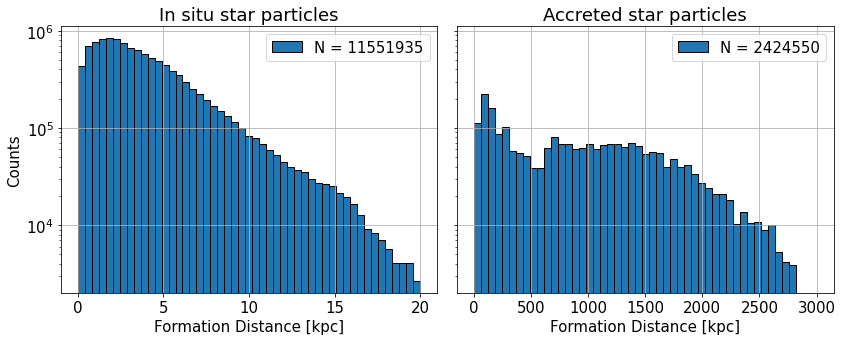

In [5]:
# plot histogram of formation distance for in situ and accreted stars separatedly
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# hist for in situ stars
bins_insitu = np.linspace(0., 20, 50)
ax1.hist(form_distance_insitu, bins_insitu, edgecolor='k')

# hist for accreted stars
bins_accreted = np.linspace(0., 3000, 50)
ax2.hist(form_distance_accreted, bins_accreted, edgecolor='k')

# format axes and figure
for ax in (ax1, ax2):
    ax.set_xlabel('Formation Distance [kpc]')
    ax.set_yscale('log')
    ax.grid(True)

ax1.set_ylabel('Counts')
ax1.set_title('In situ star particles')
ax2.set_title('Accreted star particles')
ax1.legend(['N = {}'.format(n_insitu)])
ax2.legend(['N = {}'.format(n_accreted)])

fig.tight_layout()
fig.savefig('plots/formation_distance_particles.png', 
            bbox_inches='tight', dpi=300)

In [9]:
# create labels for in situ (0) and accreted stars (1)
labels = (~mask_insitu).astype(int)
id_stars = np.arange(len(labels), dtype=int)

# write output to HDF5 file
with h5py.File('labels_mapping/accreted_insitu.hdf5', 'w') as f:
    f.attrs.update({
        '0': 'insitu',
        '1': 'accreted',
        'formation_distance_threshold': thres,
    })
    f.create_dataset('id_stars', data=id_stars, chunks=True)
    f.create_dataset('labels', data=labels, chunks=True)

# write output to txt file
# header = 'label: in situ (0) and accreted (1)\n'\
#          'formation distance threshold: {:d} kpc'.format(thres)
# np.savetxt('star_particle_labels.txt', labels, fmt='%.d', 
#            header=header, encoding='UTF-8')

### Accretion properties

If the star particle is accreted, we would like to know the properties of the accretion, specifically the merger time and the subhalo mass of the host. Unfortunately, tracing the star particles to its original subhalo is not trivial, so we do not have access to this information for all accreted star particles.

In [11]:
# use pandas to read CSV tabel with the accretion history of stars 
df = pd.read_csv('stars_accretion_history_m12i.csv')
df

,Unnamed: 0,id_stars,subhalo_mass_stars,snap_list_stars,subhalo_stellar_mass_stars,subhalo_peak_mass,feH,xstar,ystar,zstar,vxstar,vystar,vzstar,vrstar,vthetastar,vphistar,radial_distance_stars,redshift_stars,star_mass
0,0,5169899,1.459972e+08,33,7.371411e+04,1.460114e+08,-3.872613,21.855684,7.534720,-19.339868,-140.569855,60.725929,-126.513802,-5.571739,169.607751,103.225148,30.140893,8.000000,4807.344696
1,1,13182115,1.583191e+08,36,6.245729e+04,1.582621e+08,-3.850099,-20.599194,-4.364358,-18.494432,-52.153030,-51.585083,156.242432,-56.740439,-158.115938,39.655134,28.025318,7.597015,4816.955445
2,2,11086177,4.088034e+08,40,1.557363e+05,4.088319e+08,-3.346112,-5.935938,-1.542806,22.579305,186.507812,122.961258,11.720099,-44.114741,-207.120211,-72.090939,23.397449,7.112676,4594.036933
3,3,7804059,1.775071e+09,42,2.131259e+06,1.774929e+09,-3.669244,-0.628998,32.604906,15.783174,215.252899,72.435753,72.974480,93.242430,-35.944188,-216.609991,36.229603,6.897436,4731.383832
4,4,6393013,6.705556e+07,46,2.220021e+05,NaN,-2.888893,15.555391,8.905544,-20.309101,16.739494,22.457956,-178.906952,151.132912,99.127567,11.173016,27.087607,6.512195,4790.303007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433796,433796,13571279,1.867094e+08,500,1.058130e+07,8.310541e+09,-1.729493,18.458616,-1.013697,-5.323527,276.053131,-17.657347,-256.789368,336.864208,170.218038,-2.493495,19.237672,0.169460,4827.103048
433797,433797,13571300,1.867094e+08,500,1.058130e+07,8.310541e+09,-2.267073,17.474989,-0.698248,-7.434331,285.953705,15.996737,-245.879303,358.556332,114.754548,27.400715,19.003475,0.169460,4895.890872
433798,433798,13571600,1.867094e+08,500,1.058130e+07,8.310541e+09,-1.736089,14.734868,1.979008,-4.086143,312.788971,131.279617,-223.257416,374.937814,128.487072,88.475194,15.418475,0.169460,4806.705410
433799,433799,13774927,1.867094e+08,500,1.058130e+07,8.310541e+09,-1.663631,-23.075294,-7.198444,5.334399,346.392700,2.589467,33.886330,-316.357144,-104.516907,100.683985,24.753639,0.169460,5310.879814


In [12]:
# read in properties of interest
# this includes: mass properties of the subhalo and redshift
properties = ['id_stars', 'subhalo_mass_stars', 'subhalo_peak_mass', 'subhalo_stellar_mass_stars',
              'redshift_stars']
temp = df[properties].to_numpy()
data = {}
for i, prop in enumerate(properties):
    data[prop] = temp[:, i]
    
# below 10^9 solar mass, FIRE does not have sufficient mass resolution, 
# so we want to consider only stars with subhalo mass above 10^9
mask = (data['subhalo_mass_stars'] > 1e9)
for k, v, in data.items():
    data[k] = v[mask]
    
# check if redshift and subhalo mass is available for all stars
np.where(np.isnan(data['redshift_stars'])), np.where(np.isnan(data['subhalo_mass_stars']))

((array([], dtype=int64),), (array([], dtype=int64),))

In [13]:
# define a mass threshold and redshift threshold
mass_thres = 1e10
z_thres = 3

n_total = len(data['subhalo_mass_stars'])

mass_labels = (data['subhalo_mass_stars'] > mass_thres)
z_labels = (data['redshift_stars'] > z_thres)

mass_z_labels = np.zeros(n_total)
mass_z_labels[np.where(~mass_labels & ~z_labels)[0]] = 0
mass_z_labels[np.where(~mass_labels & z_labels)[0]] = 1
mass_z_labels[np.where(mass_labels & ~z_labels)[0]] = 2
mass_z_labels[np.where(mass_labels & z_labels)[0]] = 3


print('Total number of stars: {:d}'.format(n_total))
print('Number of stars with subhalo mass < {:.0e} Msun: {:d}'.format(
    mass_thres, np.sum(mass_labels==0)))
print('Number of stars with subhalo mass > {:.0e} Msun: {:d}'.format(
    mass_thres, np.sum(mass_labels==1)))
print('Number of relaxed stars (z < {:.2f})    : {:d}'.format(
    z_thres, np.sum(z_labels==0)))
print('Number of non-relaxed stars (z > {:.2f}): {:d}'.format(
    z_thres, np.sum(z_labels==1)))
print('Number of low-mass relaxed stars     : {:d}'.format(
    np.sum(mass_z_labels==0)))
print('Number of low-mass non-relaxed stars : {:d}'.format(
    np.sum(mass_z_labels==1)))
print('Number of high-mass relaxed stars    : {:d}'.format(
    np.sum(mass_z_labels==2)))
print('Number of high-mass non-relaxed stars: {:d}'.format(
    np.sum(mass_z_labels==3)))

Total number of stars: 283546
Number of stars with subhalo mass < 1e+10 Msun: 158788
Number of stars with subhalo mass > 1e+10 Msun: 124758
Number of relaxed stars (z < 3.00)    : 246599
Number of non-relaxed stars (z > 3.00): 36947
Number of low-mass relaxed stars     : 152900
Number of low-mass non-relaxed stars : 5888
Number of high-mass relaxed stars    : 93699
Number of high-mass non-relaxed stars: 31059


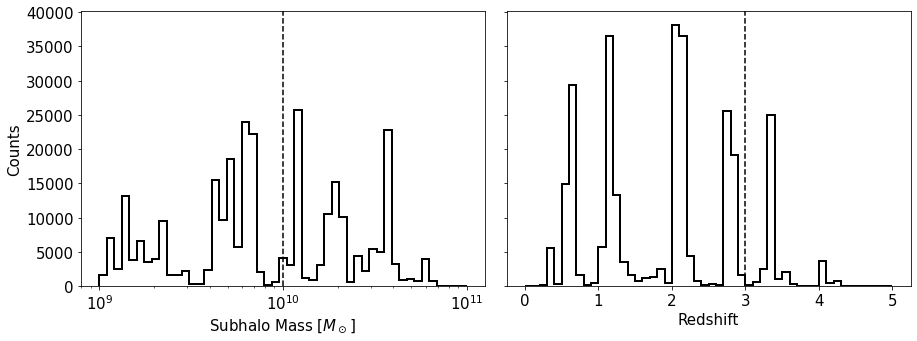

In [14]:
# plot the mass and redshift histograms of each population of stars
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 5))

bins = 10**np.linspace(9, 11, 50)
ax1.hist(data['subhalo_mass_stars'], bins=bins, 
         histtype='step', lw='2', color='k')
ax1.axvline(mass_thres, color='k', ls='--')
ax1.set_xscale('log')
ax1.set_xlabel(r'Subhalo Mass [$M_\odot$]')
ax1.set_ylabel('Counts')

bins = 50
ax2.hist(data['redshift_stars'], bins=bins, range=(0, 5),
         histtype='step', lw='2', color='k')
ax2.axvline(z_thres, color='k', ls='--')
ax2.set_xlabel(r'Redshift')

fig.tight_layout()
fig.savefig('plots/accretion_properties_particles.png', 
            bbox_inches='tight', dpi=300)

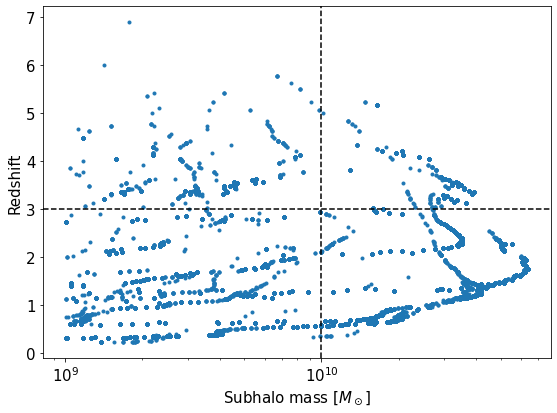

In [15]:
# plot the scatter plot of redshift vs. mass
fig, ax = plt.subplots(1)

ax.scatter(data['subhalo_mass_stars'], data['redshift_stars'], 
           marker='.')
ax.axvline(mass_thres, color='k', ls='--')
ax.axhline(z_thres, color='k', ls='--')
ax.set_xlabel(f'Subhalo mass [$M_\odot$]')
ax.set_ylabel('Redshift')
ax.set_xscale('log')

fig.tight_layout()
fig.savefig('plots/mass_z_particles.png', 
            bbox_inches='tight', dpi=300)

In [22]:
# create labels mapping for low-mass (0) and high-mass stars (1)
with h5py.File('labels_mapping/accreted_mass.h5', 'w') as f:
    f.attrs.update({
        '0': 'low_mass',
        '1': 'high_mass',
        'mass_threshold': mass_thres,
    })
    f.create_dataset('id_stars', data=data['id_stars'].astype(int), chunks=True)
    f.create_dataset('labels', data=mass_labels.astype(int), chunks=True)

# similarly, create labels mapping for relaxed (0) and non-relaxed stars (1)
with h5py.File('labels_mapping/accreted_relax.hdf5', 'w') as f:
    f.attrs.update({
        '0': 'relaxed',
        '1': 'non_relaxed',
        'z_threshold': z_thres,
    })
    f.create_dataset('id_stars', data=data['id_stars'].astype(int), chunks=True)
    f.create_dataset('labels', data=z_labels.astype(int), chunks=True)
    

# combine z and mass cut
with h5py.File('labels_mapping/accreted_mass_relax.hdf5', 'w') as f:
    f.attrs.update({
        '0': 'low_mass_relaxed',
        '1': 'low_mass_non_relaxed',
        '2': 'high_mass_relaxed',
        '3': 'high_mass_non_relaxed',
        'mass_threshold': mass_thres,
        'z_threshold': z_thres,
    })
    f.create_dataset('id_stars', data=data['id_stars'].astype(int), chunks=True)
    f.create_dataset('labels', data=mass_z_labels.astype(int), chunks=True)